In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm  # Para Q-Q plot

# Carga del dataset
df = pd.read_csv('lab-eda-bivariate/amz_uk_price_prediction_dataset.csv')


# Vista rápida
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB


In [ ]:
df['isBestSeller'].value_counts()

isBestSeller
False    2435671
True        7980
Name: count, dtype: int64

In [ ]:
# Crear la crosstab entre categoría y estado de best-seller
ct = pd.crosstab(df['category'], df['isBestSeller'])

# Verifica los nombres reales de las columnas
print(ct.columns)

Index([False, True], dtype='bool', name='isBestSeller')


In [ ]:
df['isBestSeller'].unique()

array([False,  True])

In [26]:
ct = pd.crosstab(df['category'], df['isBestSeller'])
print(ct.columns)


Index([False, True], dtype='bool', name='isBestSeller')


In [27]:
ct['prop_best_seller'] = ct[True] / (ct[True] + ct[False])


In [28]:
print(ct.columns.tolist())


[False, True, 'prop_best_seller']


In [29]:
# Crear crosstab entre categoría y best-seller
ct = pd.crosstab(df['category'], df['isBestSeller'])

# Calcular la proporción de productos best-seller por categoría
ct['prop_best_seller'] = ct[True] / (ct[True] + ct[False])

# Ordenar categorías por proporción descendente
ct_sorted = ct.sort_values('prop_best_seller', ascending=False)

# Mostrar las 10 principales categorías con mayor proporción de best-sellers
ct_sorted.head(10)


isBestSeller,False,True,prop_best_seller
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
"Billiard, Snooker & Pool",241,8,0.032129
Pet Supplies,9152,285,0.030200
Home Brewing & Wine Making,239,7,0.028455
Mirrors,243,7,0.028000


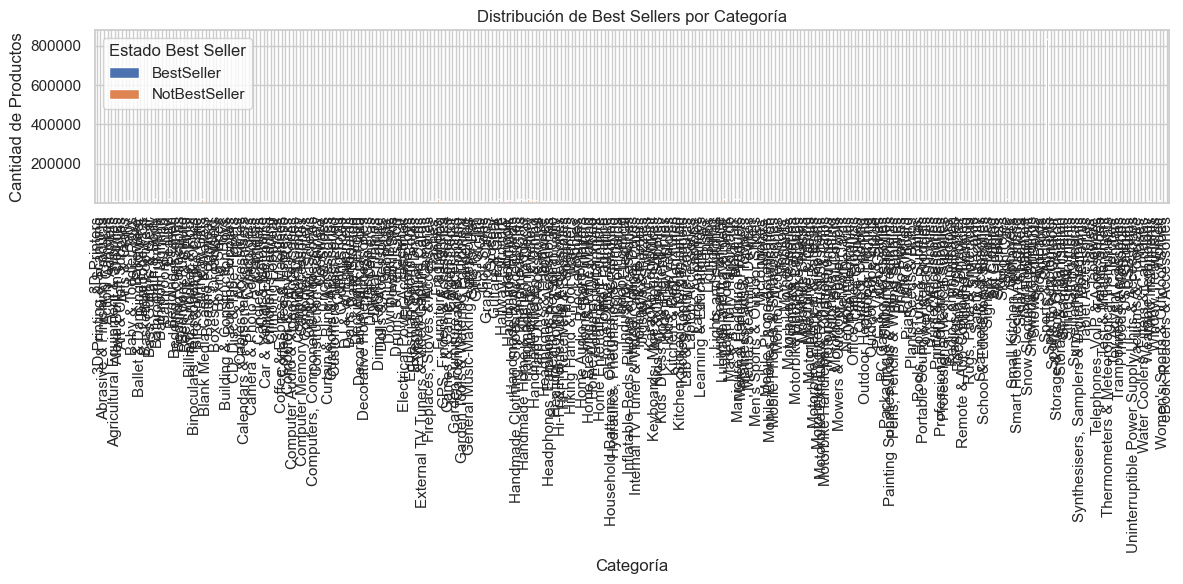

In [31]:
# Renombrar columnas de True/False a 'BestSeller' y 'NotBestSeller'
ct = ct.rename(columns={True: 'BestSeller', False: 'NotBestSeller'})

# Graficar con nombres claros
ct[['BestSeller', 'NotBestSeller']].plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribución de Best Sellers por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Productos')
plt.legend(title='Estado Best Seller')
plt.tight_layout()
plt.show()



In [32]:
# Chi-cuadrado
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['category'], df['isBestSeller']))
print(f"Chi2: {chi2}, p-valor: {p}")

# Cramér's V para fuerza de asociación
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cm = pd.crosstab(df['category'], df['isBestSeller'])
print(f"Cramér's V: {cramers_v(cm):.3f}")


Chi2: 36540.20270061387, p-valor: 0.0
Cramér's V: 0.122


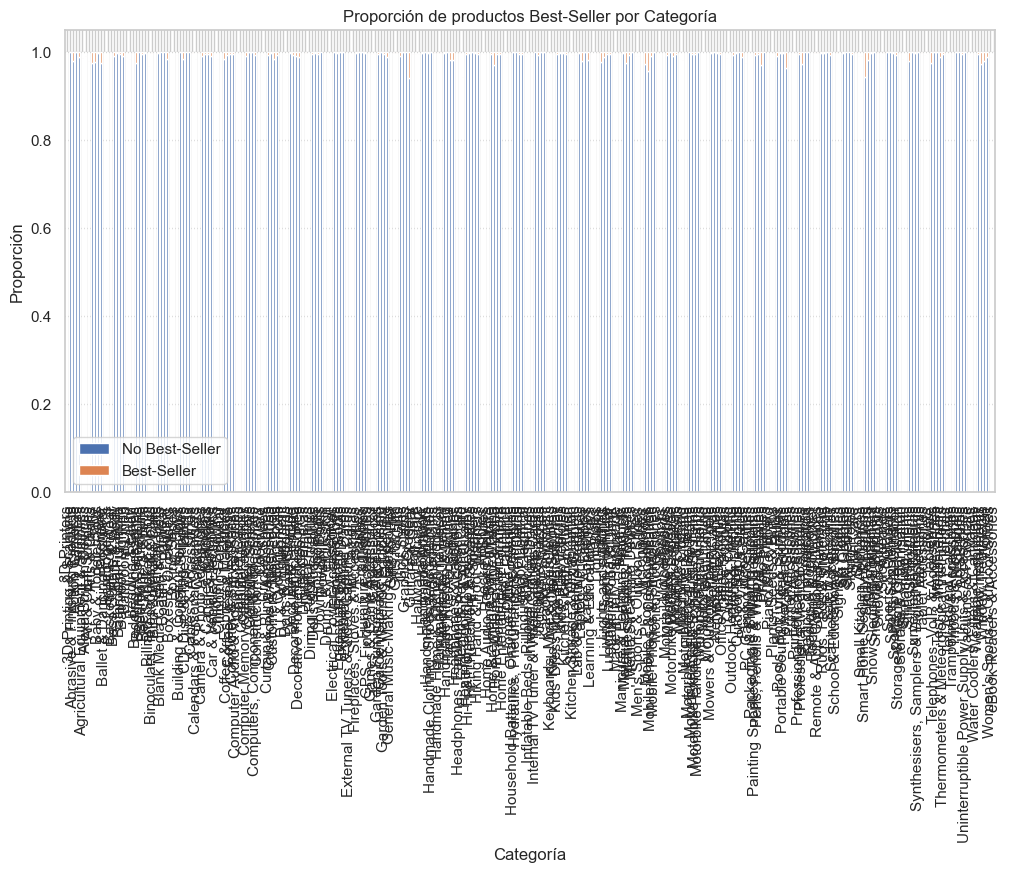

In [33]:
ct_plot = ct.drop(columns='prop_best_seller')
ct_plot_norm = ct_plot.div(ct_plot.sum(axis=1), axis=0)

ct_plot_norm.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Proporción de productos Best-Seller por Categoría')
plt.ylabel('Proporción')
plt.xlabel('Categoría')
plt.legend(['No Best-Seller', 'Best-Seller'])
plt.show()


In [34]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para precios válidos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrado
df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]


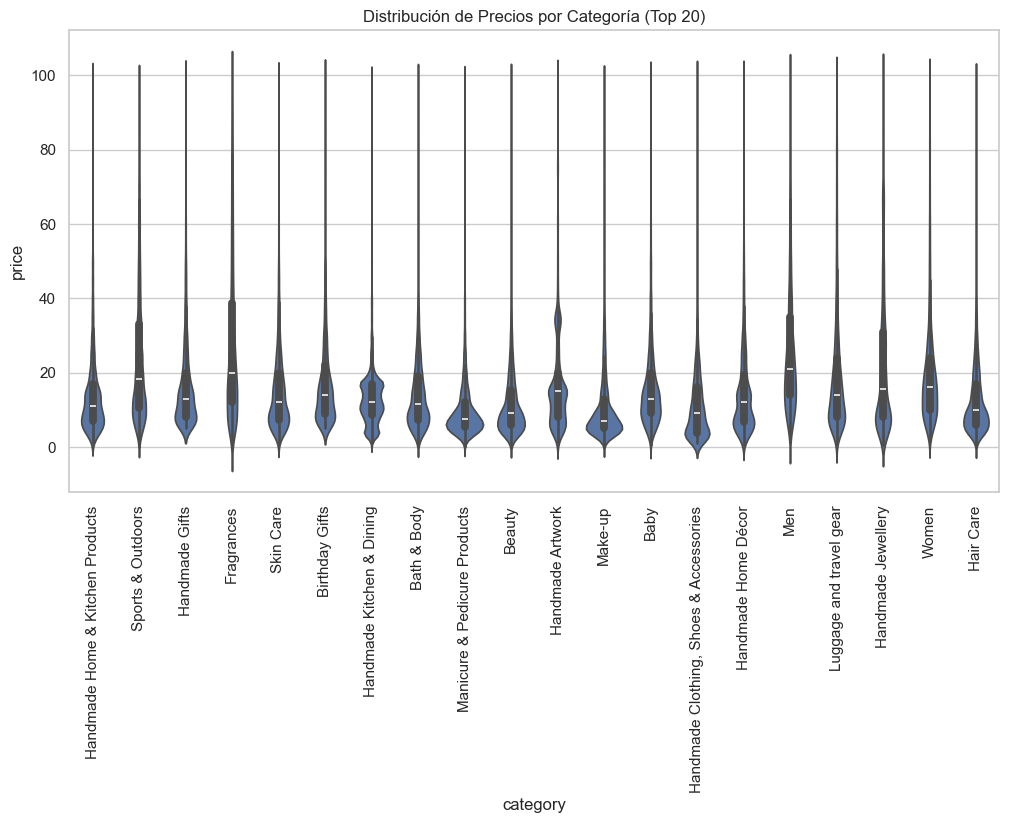

In [35]:
top20_cats = df_no_outliers['category'].value_counts().head(20).index
sns.violinplot(x='category', y='price', data=df_no_outliers[df_no_outliers['category'].isin(top20_cats)])
plt.xticks(rotation=90)
plt.title('Distribución de Precios por Categoría (Top 20)')
plt.show()


In [36]:
median_prices = df_no_outliers.groupby('category')['price'].median().sort_values(ascending=False)
print("Categoría con mayor mediana de precio:")
print(median_prices.head(1))


Categoría con mayor mediana de precio:
category
Desktop PCs    74.0
Name: price, dtype: float64


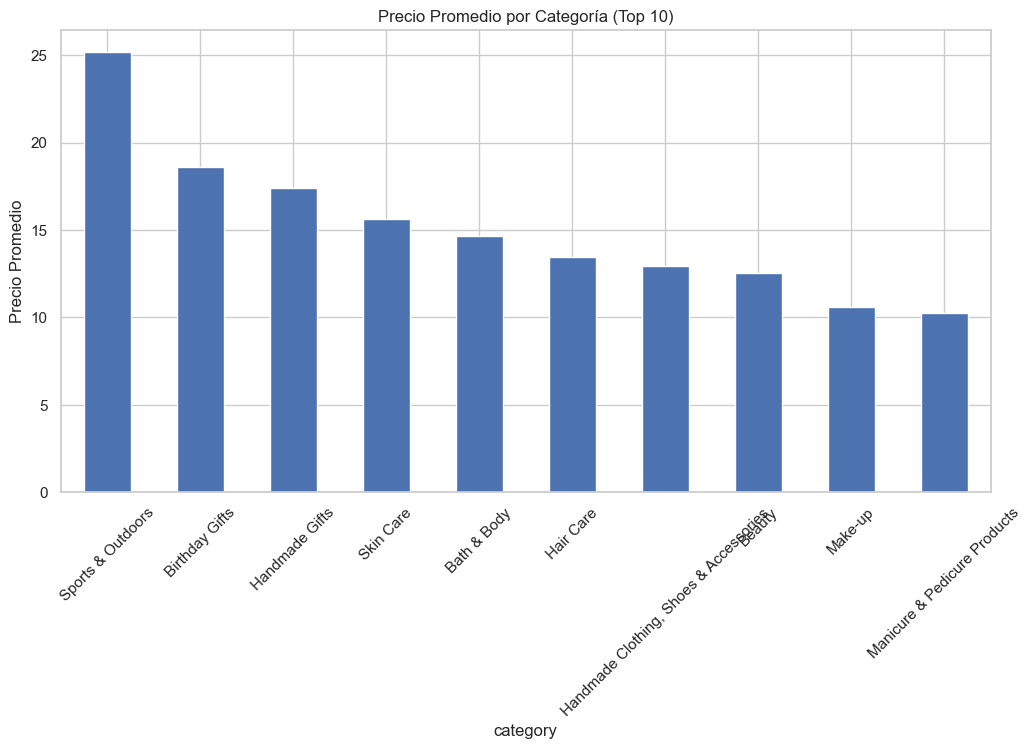

Categoría con precio promedio más alto:
category
Sports & Outdoors    25.172065
Name: price, dtype: float64


In [37]:
top10_cats = df_no_outliers['category'].value_counts().head(10).index
avg_prices = df_no_outliers[df_no_outliers['category'].isin(top10_cats)].groupby('category')['price'].mean().sort_values(ascending=False)

avg_prices.plot(kind='bar')
plt.title('Precio Promedio por Categoría (Top 10)')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=45)
plt.show()

print("Categoría con precio promedio más alto:")
print(avg_prices.head(1))


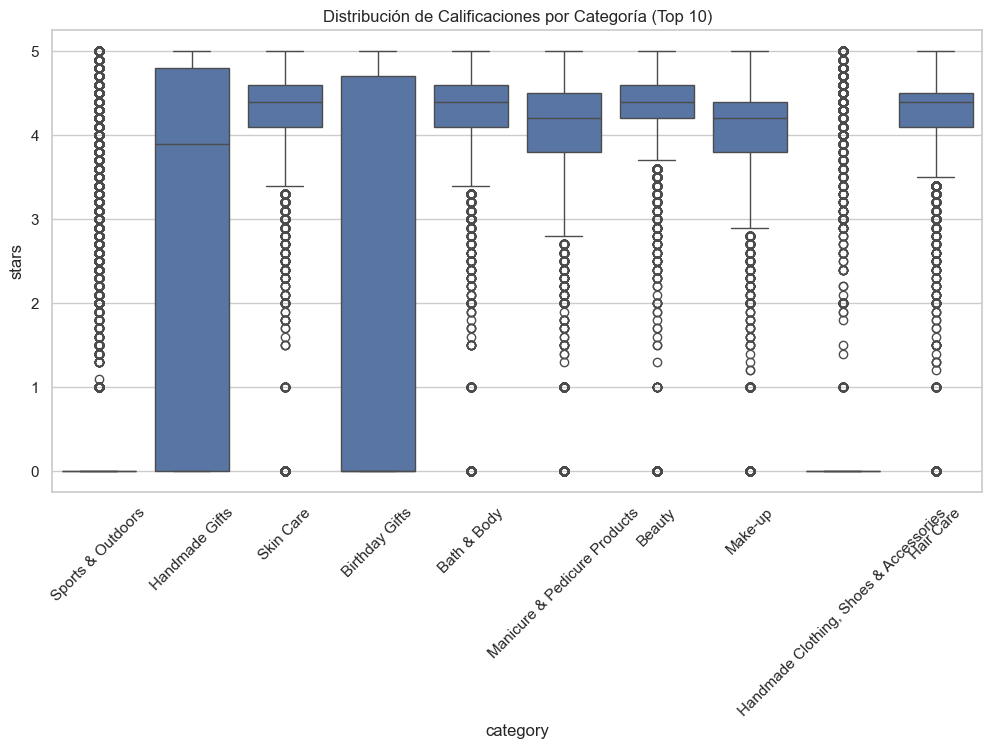

Categoría con mayor mediana de calificación:
category
Computer Memory    4.7
Name: stars, dtype: float64


In [38]:
sns.boxplot(x='category', y='stars', data=df_no_outliers[df_no_outliers['category'].isin(top10_cats)])
plt.xticks(rotation=45)
plt.title('Distribución de Calificaciones por Categoría (Top 10)')
plt.show()

median_ratings = df_no_outliers.groupby('category')['stars'].median().sort_values(ascending=False)
print("Categoría con mayor mediana de calificación:")
print(median_ratings.head(1))


In [39]:
corr_pearson, p_pearson = pearsonr(df_no_outliers['price'], df_no_outliers['stars'])
print(f"Correlación de Pearson (precio, estrellas): {corr_pearson:.3f}, p-valor: {p_pearson:.4f}")


Correlación de Pearson (precio, estrellas): -0.078, p-valor: 0.0000


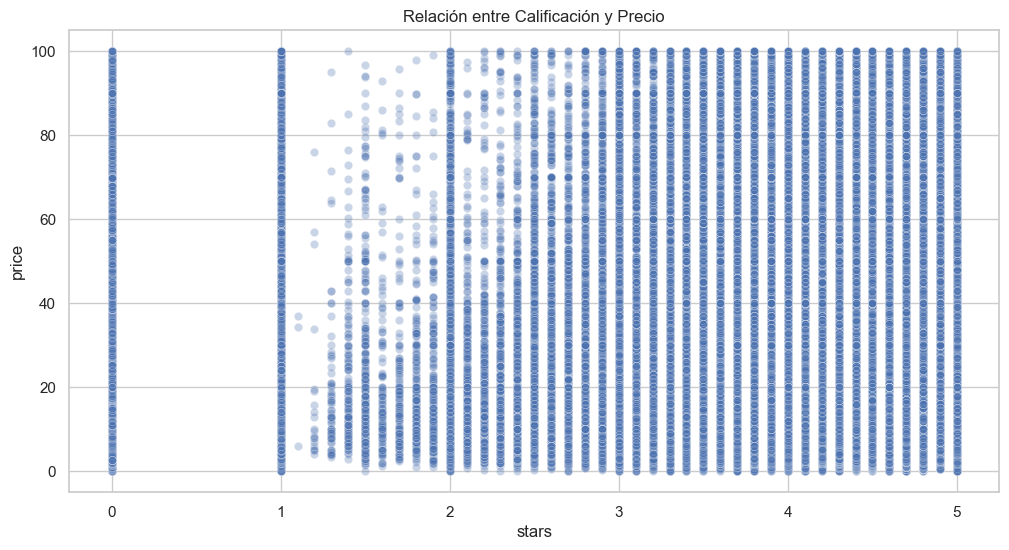

In [40]:
sns.scatterplot(x='stars', y='price', data=df_no_outliers, alpha=0.3)
plt.title('Relación entre Calificación y Precio')
plt.show()


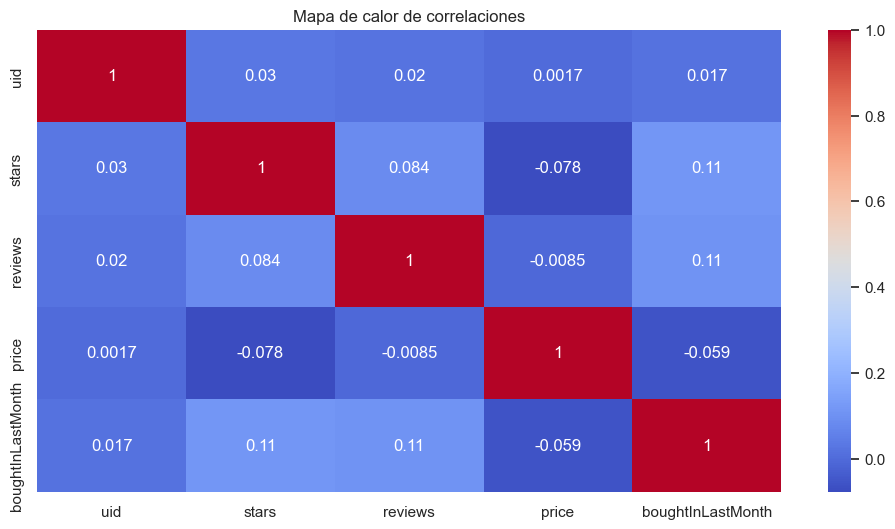

In [41]:
corr_matrix = df_no_outliers.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlaciones')
plt.show()


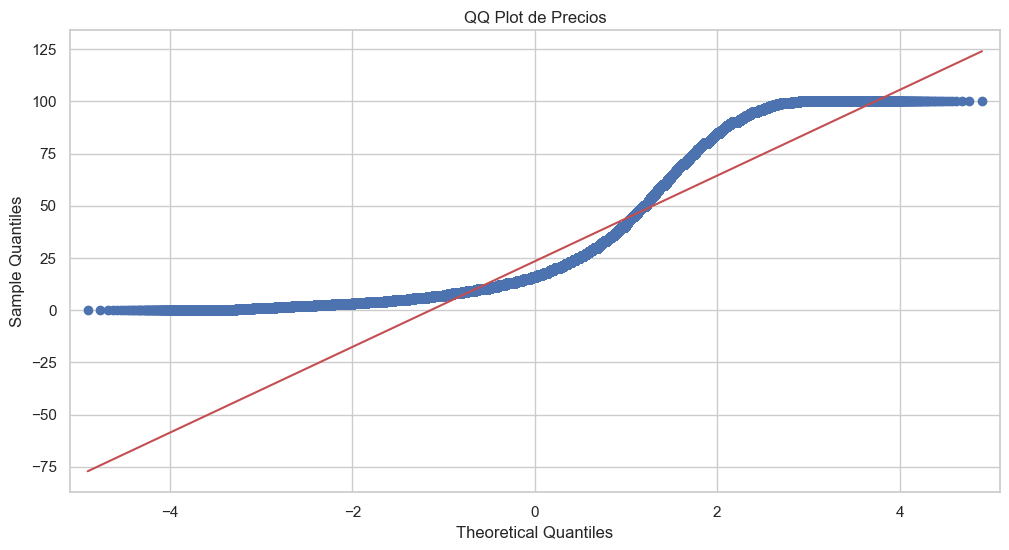

In [42]:
sm.qqplot(df_no_outliers['price'], line='s')
plt.title('QQ Plot de Precios')
plt.show()
